

# 🏥 Medical AI Assistant
## От пикселей к диагнозу  
### *Мультимодальная система анализа медицинских изображений и интеллектуальных консультаций*





In [ ]:
!pip install -r requirements.txt

In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision import models
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import yaml
import random
from ultralytics import YOLO

##*Классификация опухолей мозга на МРТ*

### *Визуализация исходных данных*

✅ Папка найдена

🎯 Классы для классификации: ['glioma', 'meningioma', 'notumor', 'pituitary']
Всего классов: 4

📊 Распределение по классам:
  glioma: 1321 изображений
  meningioma: 1339 изображений
  notumor: 1595 изображений
  pituitary: 1457 изображений

👀 Примеры изображений:


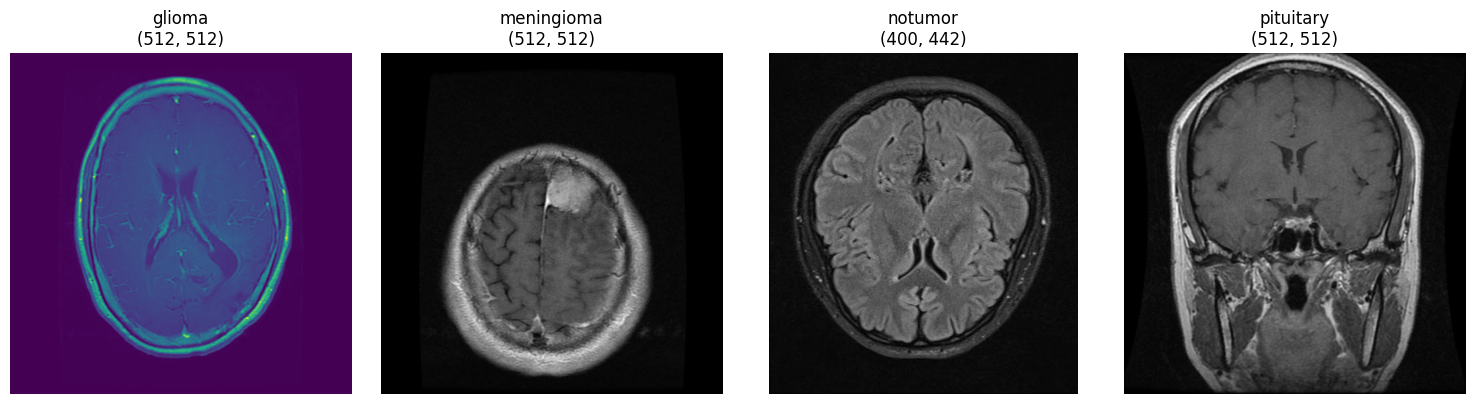

In [12]:
# Путь к данным
project_path = Path("/medical-project/mrt_data")
train_path = project_path / "Training"

# Проверяем, что папка существует
if not train_path.exists():
    print(f"❌ Папка {train_path} не найдена. Проверьте структуру.")
    # Покажем, что есть
    print("Содержимое проекта:")
    for item in project_path.iterdir():
        print(f"  - {item.name}")
else:
    print(f"✅ Папка найдена")

    # Смотрим классы (папки)
    classes = sorted([d.name for d in train_path.iterdir() if d.is_dir()])
    print(f"\n🎯 Классы для классификации: {classes}")
    print(f"Всего классов: {len(classes)}")

    # Считаем количество изображений в каждом классе
    print("\n📊 Распределение по классам:")
    for cls in classes:
        class_path = train_path / cls
        images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.png"))
        print(f"  {cls}: {len(images)} изображений")

    # Показываем по одному примеру из каждого класса
    print("\n👀 Примеры изображений:")
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 4))

    for idx, cls in enumerate(classes):
        class_path = train_path / cls
        images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.png"))
        if images:
            img = Image.open(images[0])
            axes[idx].imshow(img)
            axes[idx].set_title(f"{cls}\n{img.size}")
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, 'Нет\nизображений', ha='center')
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

### *Создание dataloaders*

📁 Загружаю датасет...
✅ Всего изображений: 5712
   Классы: ['glioma', 'meningioma', 'notumor', 'pituitary']

📊 Разделение:
   Обучающая выборка: 4569 изображений
   Валидационная выборка: 1143 изображений

🎯 DataLoader созданы (размер батча: 16)

👀 Проверяем батч данных...
   Размер тензора с изображениями: torch.Size([16, 3, 224, 224])
   Размер тензора с метками: torch.Size([16])


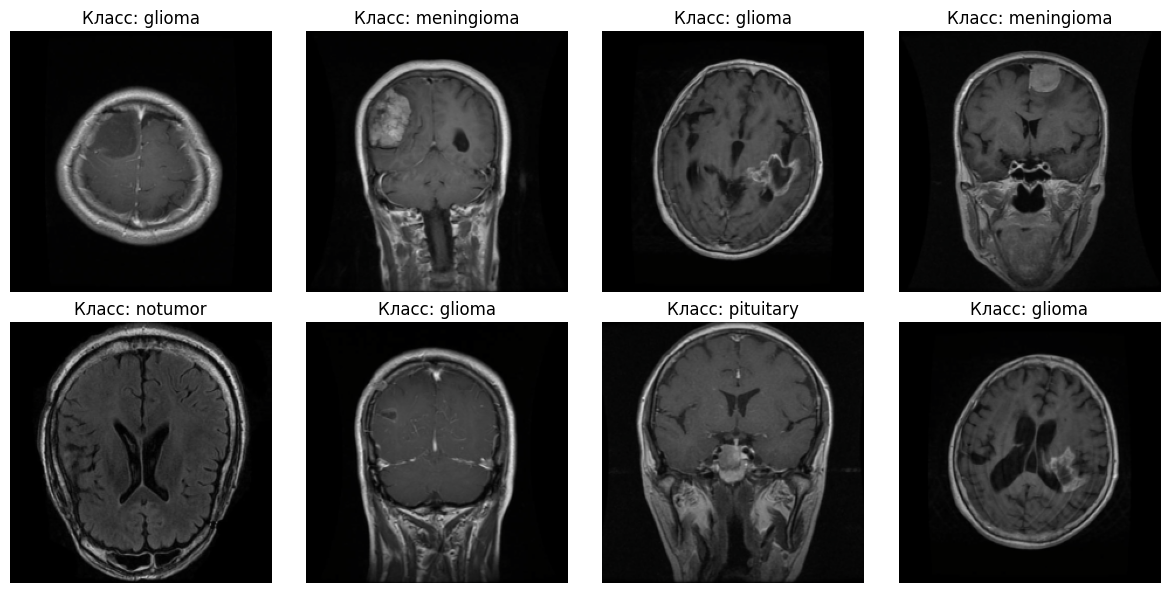

In [ ]:
# Путь к данным
project_path = Path("/medical-project/mrt_data")
train_path = project_path / "Training"

# 1. Определим преобразования для изображений
#    Нормализация под PyTorch и изменение размера
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),       # Приводим все к одному размеру
    transforms.ToTensor(),               # Преобразуем в тензор PyTorch
    transforms.Normalize(                # Нормализуем как стандартные ImageNet изображения
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Создаем датасет из папки
print("📁 Загружаю датасет...")
full_dataset = datasets.ImageFolder(root=str(train_path), transform=data_transforms)
print(f"✅ Всего изображений: {len(full_dataset)}")
print(f"   Классы: {full_dataset.classes}")

# 3. Разделяем на обучающую и валидационную выборку
train_size = int(0.8 * len(full_dataset))  # 80% на обучение
val_size = len(full_dataset) - train_size  # 20% на проверку

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
print(f"\n📊 Разделение:")
print(f"   Обучающая выборка: {len(train_dataset)} изображений")
print(f"   Валидационная выборка: {len(val_dataset)} изображений")

# 4. Создаем DataLoader'ы (они подают данные батчами)
batch_size = 16  # Количество изображений за один шаг

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True)

print(f"\n🎯 DataLoader созданы (размер батча: {batch_size})")

# 5. Покажем один батч из обучающей выборки
print("\n👀 Проверяем батч данных...")
images, labels = next(iter(train_loader))

print(f"   Размер тензора с изображениями: {images.shape}")  # [batch, channels, height, width]
print(f"   Размер тензора с метками: {labels.shape}")       # [batch]

# Визуализируем несколько изображений из батча
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for idx in range(min(8, batch_size)):  # Покажем первые 8 изображений
    img = images[idx].permute(1, 2, 0).numpy()  # Меняем порядок осей для matplotlib
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Обратная нормализация
    img = np.clip(img, 0, 1)  # Ограничиваем значения [0, 1]

    axes[idx].imshow(img)
    axes[idx].set_title(f"Класс: {full_dataset.classes[labels[idx]]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### *Обучение модели ResNet*

In [ ]:
# Проверяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🎯 Использую устройство: {device}")

# 1. Создаем модель на основе предобученной ResNet
print("\n🧠 Создаю модель...")

# Загружаем предобученную ResNet18
model = models.resnet18(weights='IMAGENET1K_V1')

# Заменяем последний полносвязный слой (он был для 1000 классов ImageNet)
num_classes = len(full_dataset.classes)  # Количество наших классов (glioma, meningioma и т.д.)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Перемещаем модель на GPU, если доступно
model = model.to(device)
print(f"✅ Модель создана. Количество классов: {num_classes}")

# 2. Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam — популярный оптимизатор

# 3. Функция для одной эпохи обучения
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc="Обучение", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обратный проход
        loss.backward()
        optimizer.step()

        # Статистика
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Обновляем progress bar
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# 4. Функция для валидации
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Отключаем вычисление градиентов
        for images, labels in tqdm(loader, desc="Валидация", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# 5. Обучаем модель на 2 эпохах (для проверки)
print("\n🚀 Начинаю обучение (2 эпохи)...")
num_epochs = 2

for epoch in range(num_epochs):
    start_time = time.time()
    print(f"\nЭпоха {epoch+1}/{num_epochs}")

    # Обучение
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Валидация
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    epoch_time = time.time() - start_time
    print(f"   Время: {epoch_time:.1f} сек.")
    print(f"   Потери: обучение={train_loss:.4f}, валидация={val_loss:.4f}")
    print(f"   Точность: обучение={train_acc:.2f}%, валидация={val_acc:.2f}%")

print("\n✅ Обучение завершено!")

🎯 Использую устройство: cuda

🧠 Создаю модель...
✅ Модель создана. Количество классов: 4

🚀 Начинаю обучение (2 эпохи)...

Эпоха 1/2


   Время: 1353.7 сек.
   Потери: обучение=0.4165, валидация=0.3139
   Точность: обучение=85.16%, валидация=90.46%

Эпоха 2/2


   Время: 42.3 сек.
   Потери: обучение=0.2535, валидация=0.1736
   Точность: обучение=91.29%, валидация=93.96%

✅ Обучение завершено!


### *Grad-CAM — визуализация, показывающая, на какие области снимка модель смотрела, принимая решение*

🎯 Генерирую Grad-CAM визуализации...


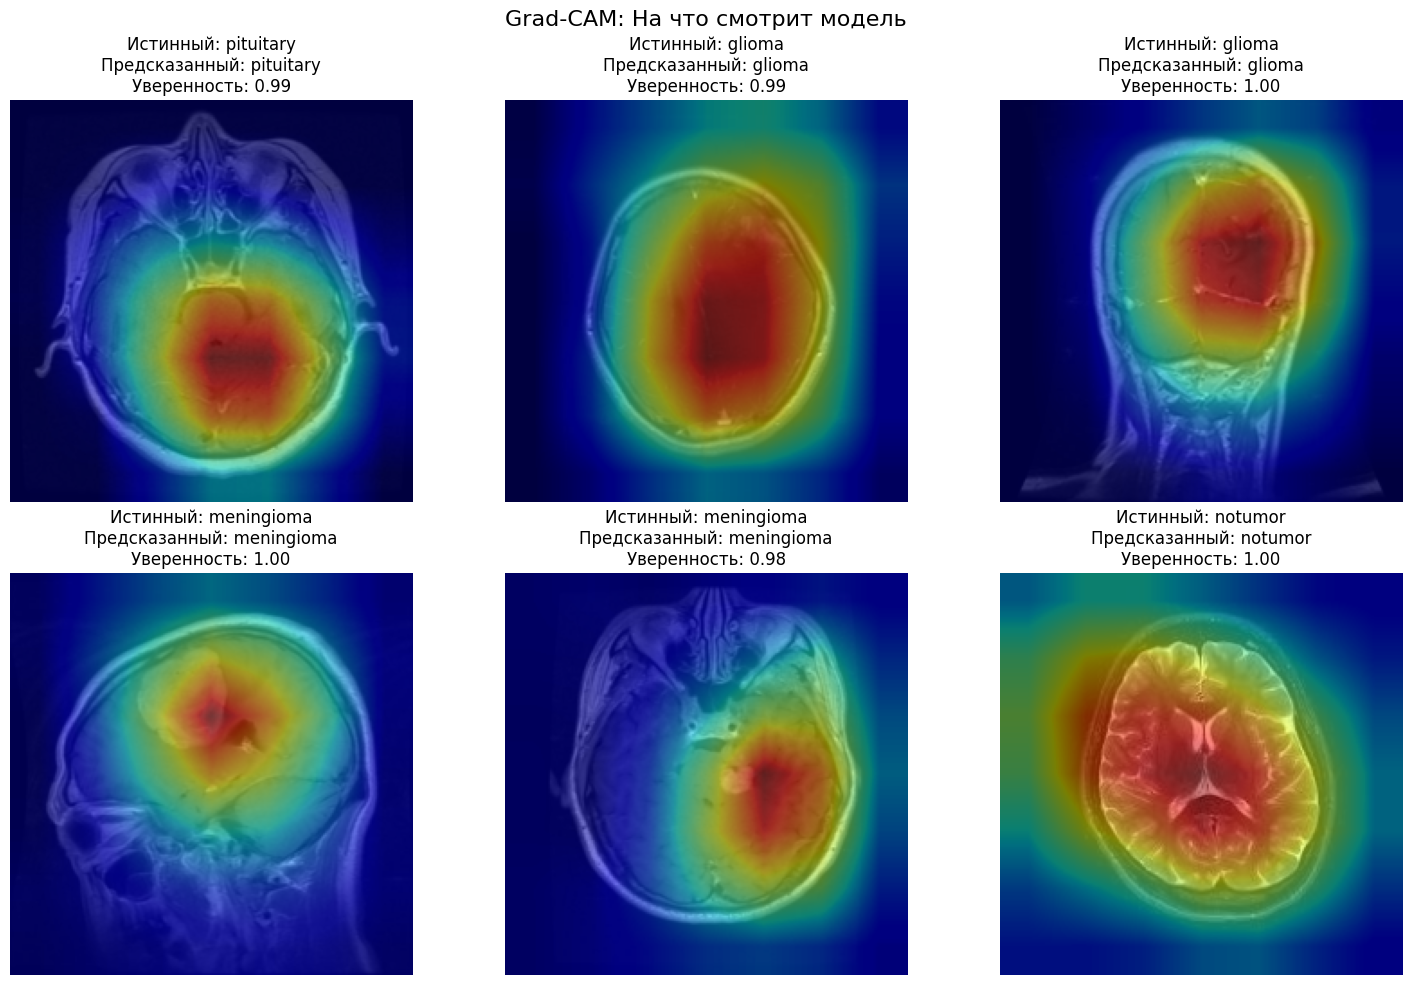

In [ ]:
# Grad-CAM implementation
def grad_cam(model, img_tensor, target_layer):
    """
    Генерирует heatmap Grad-CAM для одного изображения
    """
    model.eval()

    # 1. Хук для получения градиентов и активаций
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # 2. Регистрируем хуки
    handle_backward = target_layer.register_full_backward_hook(backward_hook)
    handle_forward = target_layer.register_forward_hook(forward_hook)

    # 3. Прямой проход
    output = model(img_tensor.unsqueeze(0).to(device))
    probs = F.softmax(output, dim=1)
    pred_class = output.argmax(dim=1).item()

    # 4. Обратный проход для нужного класса
    model.zero_grad()
    output[0, pred_class].backward()

    # 5. Получаем градиенты и активации
    grad = gradients[0].cpu().data.numpy()[0]
    act = activations[0].cpu().data.numpy()[0]

    # 6. Вычисляем веса и heatmap
    weights = np.mean(grad, axis=(1, 2))
    heatmap = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        heatmap += w * act[i]

    # 7. Нормализуем heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (heatmap.max() + 1e-10)

    # 8. Изменяем размер heatmap до размера изображения (с помощью OpenCV или PIL)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (heatmap.max() + 1e-10)

    # 9. Удаляем хуки
    handle_backward.remove()
    handle_forward.remove()

    return heatmap, pred_class, probs[0, pred_class].item()

# Берем несколько случайных изображений из валидации
print("🎯 Генерирую Grad-CAM визуализации...")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Выбираем слой для Grad-CAM (последний сверточный слой ResNet)
target_layer = model.layer4[-1]

for i in range(6):
    row, col = i // 3, i % 3

    # Берем случайное изображение
    idx = torch.randint(0, len(val_dataset), (1,)).item()
    img_tensor, true_label = val_dataset[idx]

    # Получаем Grad-CAM
    heatmap, pred_class, confidence = grad_cam(model, img_tensor, target_layer)

    # Подготавливаем изображение для отображения
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    # Наложение heatmap
    heatmap_resized = np.uint8(255 * heatmap)
    heatmap_rgb = plt.cm.jet(heatmap_resized)[:, :, :3]

    alpha = 0.5
    superimposed = heatmap_rgb * alpha + img * (1 - alpha)

    # Отображение
    axes[row, col].imshow(superimposed)
    axes[row, col].set_title(
        f"Истинный: {full_dataset.classes[true_label]}\n"
        f"Предсказанный: {full_dataset.classes[pred_class]}\n"
        f"Уверенность: {confidence:.2f}"
    )
    axes[row, col].axis('off')

plt.suptitle("Grad-CAM: На что смотрит модель", fontsize=16)
plt.tight_layout()
plt.show()

### *Пример сохранения модели (выполнено ранее)*

In [ ]:
# Путь для сохранения
save_dir = Path("/medical-project/models")
save_dir.mkdir(exist_ok=True)

# 1. Сохраняем всю модель (архитектура + веса)
model_path = save_dir / "brain_mri_classifier.pth"
torch.save(model, model_path)
print(f"✅ Модель сохранена: {model_path}")

# 2. Сохраняем только веса (легче, но нужно знать архитектуру)
weights_path = save_dir / "brain_mri_classifier_weights.pth"
torch.save(model.state_dict(), weights_path)
print(f"✅ Веса сохранены: {weights_path}")

# 3. Сохраняем информацию о классах
class_info = {
    'classes': full_dataset.classes,
    'class_to_idx': full_dataset.class_to_idx
}

import json
class_info_path = save_dir / "class_info.json"
with open(class_info_path, 'w') as f:
    json.dump(class_info, f)
print(f"✅ Информация о классах сохранена: {class_info_path}")

# Проверяем размер
print(f"\n📦 Размер файла модели: {model_path.stat().st_size / (1024**2):.2f} МБ")

### *Тестирование модели*

🔍 Тестирую на папке: /content/drive/MyDrive/medical-project/Testing
📊 Тестовых изображений: 1311
   Классы: ['glioma', 'meningioma', 'notumor', 'pituitary']

🧪 Начинаю тестирование...
✅ Точность на тестовой выборке: 93.36%

📈 Матрица ошибок:


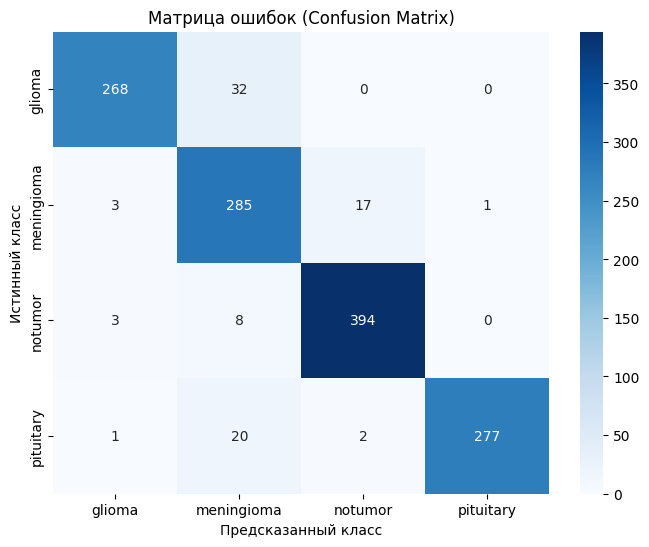


📊 Подробный отчет по классам:
              precision    recall  f1-score   support

      glioma       0.97      0.89      0.93       300
  meningioma       0.83      0.93      0.88       306
     notumor       0.95      0.97      0.96       405
   pituitary       1.00      0.92      0.96       300

    accuracy                           0.93      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.93      0.93      1311


🔍 Примеры предсказаний:


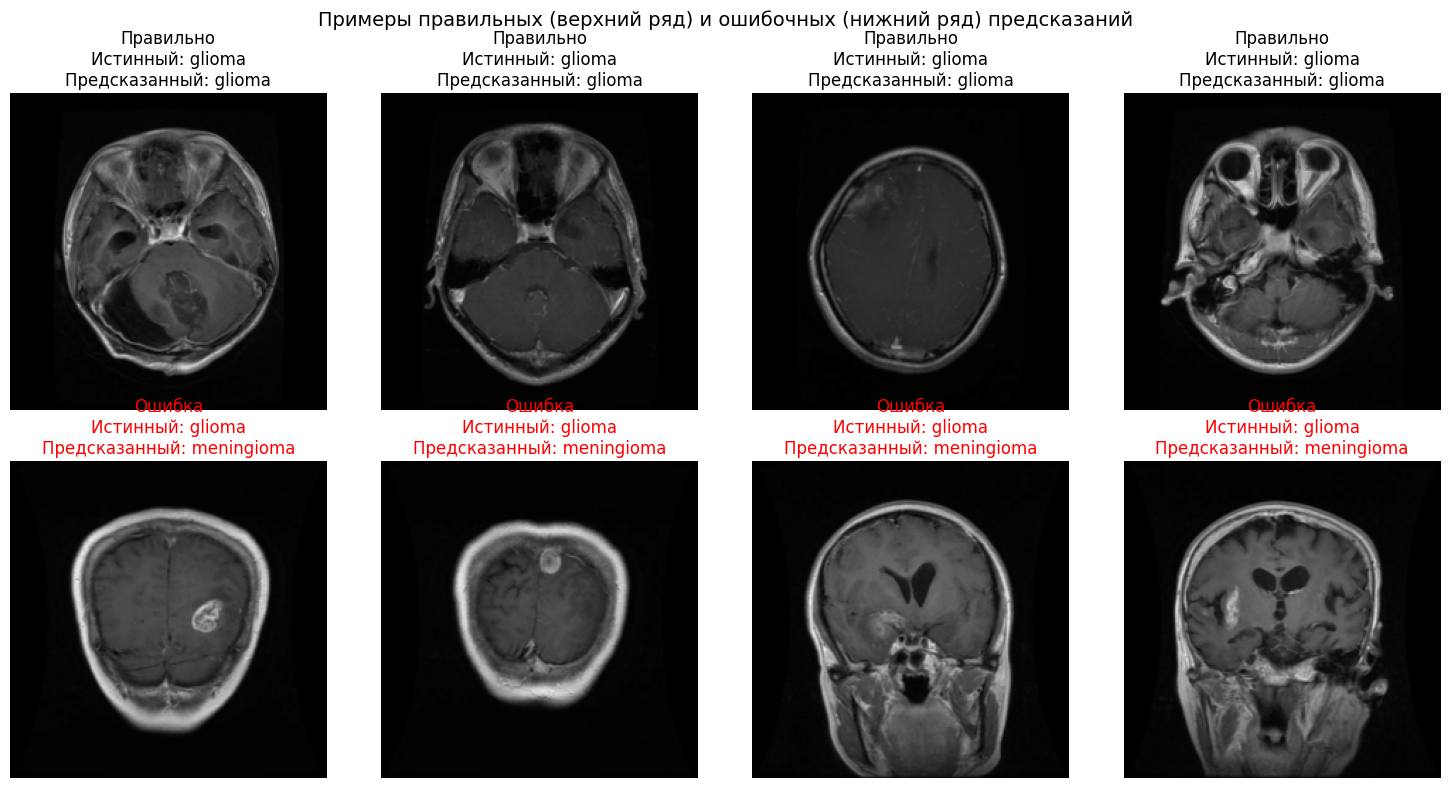

In [ ]:
# Путь к тестовым данным
test_path = Path("medical-project/Testing")
print(f"🔍 Тестирую на папке: {test_path}")

# Те же преобразования, что и для обучения
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Создаем тестовый датасет
test_dataset = datasets.ImageFolder(root=str(test_path), transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2,pin_memory=True)

print(f"📊 Тестовых изображений: {len(test_dataset)}")
print(f"   Классы: {test_dataset.classes}")

# Переводим модель в режим оценки
model.eval()

all_preds = []
all_labels = []
all_probs = []

print("\n🧪 Начинаю тестирование...")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# 1. Общая точность
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"✅ Точность на тестовой выборке: {accuracy*100:.2f}%")

# 2. Матрица ошибок
print("\n📈 Матрица ошибок:")
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm,
                     index=test_dataset.classes,
                     columns=test_dataset.classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# 3. Подробный отчет
print("\n📊 Подробный отчет по классам:")
print(classification_report(all_labels, all_preds,
                           target_names=test_dataset.classes))

# 4. Примеры правильных и ошибочных предсказаний
print("\n🔍 Примеры предсказаний:")
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

correct_indices = np.where(np.array(all_preds) == np.array(all_labels))[0]
wrong_indices = np.where(np.array(all_preds) != np.array(all_labels))[0]

# Правильные предсказания
for i in range(4):
    if i < len(correct_indices):
        idx = correct_indices[i]
        img, true_label = test_dataset[idx]

        # Денормализация для отображения
        img_display = img.permute(1, 2, 0).cpu().numpy()
        img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_display = np.clip(img_display, 0, 1)

        axes[i].imshow(img_display)
        axes[i].set_title(f"Правильно\nИстинный: {test_dataset.classes[true_label]}\nПредсказанный: {test_dataset.classes[all_preds[idx]]}")
        axes[i].axis('off')

# Ошибочные предсказания
for i in range(4):
    if i < len(wrong_indices):
        idx = wrong_indices[i]
        img, true_label = test_dataset[idx]

        img_display = img.permute(1, 2, 0).cpu().numpy()
        img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_display = np.clip(img_display, 0, 1)

        axes[i+4].imshow(img_display)
        axes[i+4].set_title(f"Ошибка\nИстинный: {test_dataset.classes[true_label]}\nПредсказанный: {test_dataset.classes[all_preds[idx]]}", color='red')
        axes[i+4].axis('off')

plt.suptitle("Примеры правильных (верхний ряд) и ошибочных (нижний ряд) предсказаний", fontsize=14)
plt.tight_layout()
plt.show()

## *Сегментация лёгких на рентгеновских снимках*

### *Визуализация исходных данных*

🔍 Проверяю класс: Normal
   Изображений: 10192
   Масок: 10192

👀 Пример:
   Изображение: Normal-9227.png
   Маска: Normal-9227.png


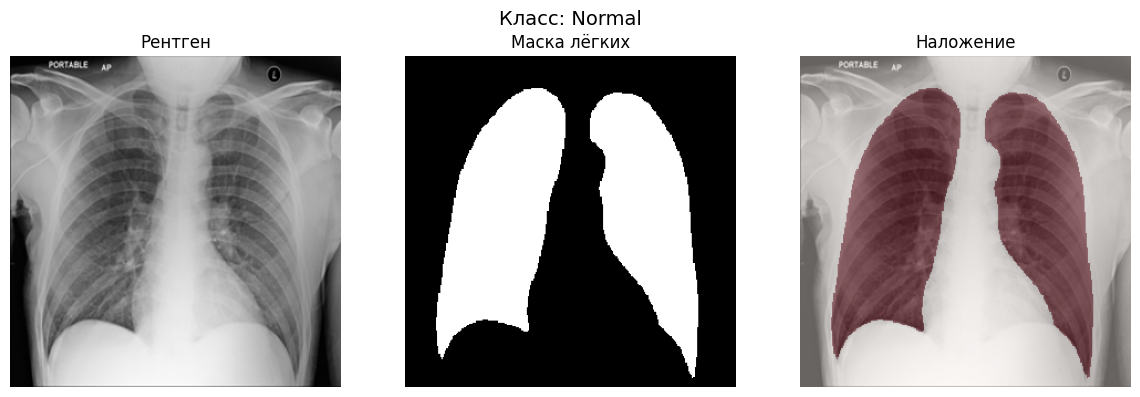

In [ ]:
# Путь к данным
data_root = Path("/lung_data/COVID-19_Radiography_Dataset")
class_name = "Normal"

# Пути к изображениям и маскам
img_dir = data_root / class_name / "images"
mask_dir = data_root / class_name / "masks"

print(f"🔍 Проверяю класс: {class_name}")
print(f"   Изображений: {len(list(img_dir.glob('*.png')))}")
print(f"   Масок: {len(list(mask_dir.glob('*.png')))}")

# Берём первое изображение и соответствующую маску
img_path = next(img_dir.glob("*.png"))
# Находим маску с таким же именем
mask_filename = img_path.name  # Например, "Normal-1.png"
mask_path = mask_dir / mask_filename

print(f"\n👀 Пример:")
print(f"   Изображение: {img_path.name}")
print(f"   Маска: {mask_path.name}")

# Показываем
if mask_path.exists():
    import numpy as np
    from PIL import Image

    img = plt.imread(img_path)
    mask = plt.imread(mask_path)

    # Исправление размера маски
    if img.shape[:2] != mask.shape[:2]:
        # 1. Преобразуем маску в uint8 (PIL требует этот тип)
        if mask.dtype != np.uint8:
            mask = (mask * 255).astype(np.uint8)

        # 2. Если маска имеет 3 канала, берём первый (или любой)
        if mask.ndim == 3:
            mask = mask[:, :, 0]

        # 3. Изменяем размер
        mask = Image.fromarray(mask).resize(img.shape[:2], Image.NEAREST)
        mask = np.array(mask)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Рентген")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Маска лёгких")
    axes[1].axis('off')

    axes[2].imshow(img, cmap='gray')
    axes[2].imshow(mask, cmap='Reds', alpha=0.4)
    axes[2].set_title("Наложение")
    axes[2].axis('off')

    plt.suptitle(f"Класс: {class_name}", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ Маска не найдена: {mask_path}")

### *Создание dataset и dataloaders*

📁 Создаю датасет для сегментации...
✅ Загружено 21165 пар (изображение + маска)
📊 Разделение:
   Обучающая выборка: 16932 пар
   Валидационная выборка: 4233 пар
🎯 DataLoader созданы (размер батча: 8)

👀 Проверяем данные...
   Размер тензора изображений: torch.Size([8, 1, 256, 256])
   Размер тензора масок: torch.Size([8, 1, 256, 256])


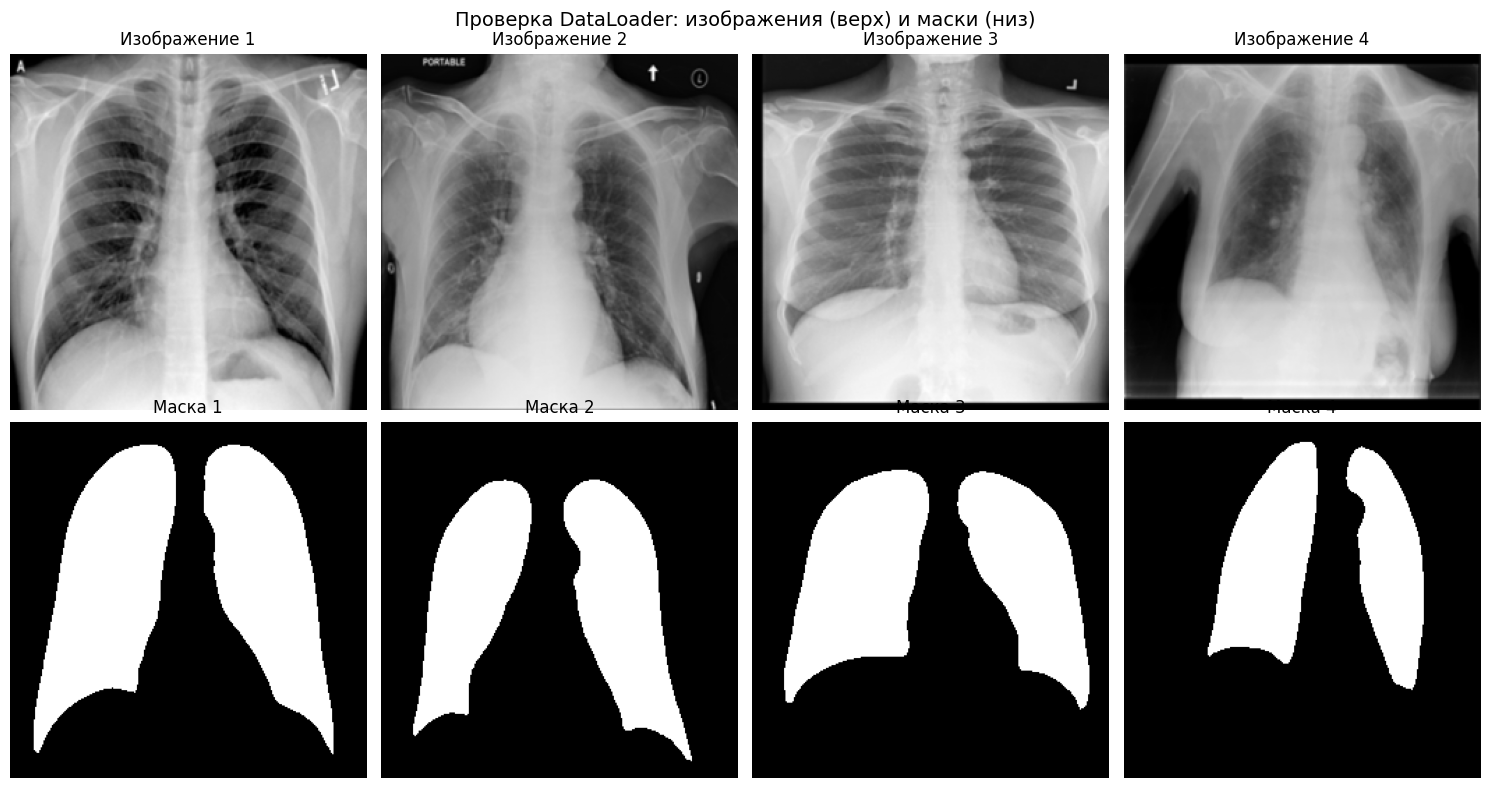

In [ ]:
# 1. Создаем свой класс датасета
class LungSegmentationDataset(Dataset):
    def __init__(self, root_dir, class_names=["Normal"], transform=None, img_size=(256, 256)):
        """
        Args:
            root_dir: путь к COVID-19_Radiography_Dataset
            class_names: список классов для использования (["Normal", "COVID", ...])
            transform: преобразования
            img_size: размер изображения (ширина, высота)
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.img_size = img_size
        self.samples = []

        # Собираем все пары (изображение, маска)
        for class_name in class_names:
            img_dir = self.root_dir / class_name / "images"
            mask_dir = self.root_dir / class_name / "masks"

            if img_dir.exists() and mask_dir.exists():
                for img_path in img_dir.glob("*.png"):
                    mask_path = mask_dir / img_path.name
                    if mask_path.exists():
                        self.samples.append((img_path, mask_path))

        print(f"✅ Загружено {len(self.samples)} пар (изображение + маска)")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        # Загружаем изображение и маску
        image = Image.open(img_path).convert("L")  # "L" = grayscale
        mask = Image.open(mask_path).convert("L")

        # Изменяем размер
        image = image.resize(self.img_size, Image.BILINEAR)
        mask = mask.resize(self.img_size, Image.NEAREST)  # NEAREST для масок

        # Преобразуем в numpy
        image = np.array(image) / 255.0  # Нормализуем [0, 1]
        mask = np.array(mask) / 255.0

        # Преобразуем в тензоры
        image = torch.FloatTensor(image).unsqueeze(0)  # [1, H, W]
        mask = torch.FloatTensor(mask).unsqueeze(0)    # [1, H, W]

        return image, mask

# 2. Создаем датасет (ВСЕ классы)
print("📁 Создаю датасет для сегментации...")
dataset = LungSegmentationDataset(
    root_dir="lung_data/COVID-19_Radiography_Dataset",
    class_names=["Normal", "COVID", "Lung_Opacity", "Viral Pneumonia"],  # ВСЕ классы
    img_size=(256, 256)
)

# 3. Разделяем на обучение и валидацию
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(f"📊 Разделение:")
print(f"   Обучающая выборка: {len(train_dataset)} пар")
print(f"   Валидационная выборка: {len(val_dataset)} пар")

# 4. Создаем DataLoader'ы
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True)

print(f"🎯 DataLoader созданы (размер батча: {batch_size})")

# 5. Показываем один батч
print("\n👀 Проверяем данные...")
images, masks = next(iter(train_loader))
print(f"   Размер тензора изображений: {images.shape}")  # [batch, 1, height, width]
print(f"   Размер тензора масок: {masks.shape}")

# Визуализируем
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for i in range(min(4, batch_size)):
    # Изображения (верхний ряд)
    axes[0, i].imshow(images[i][0], cmap='gray')
    axes[0, i].set_title(f"Изображение {i+1}")
    axes[0, i].axis('off')

    # Маски (нижний ряд)
    axes[1, i].imshow(masks[i][0], cmap='gray')
    axes[1, i].set_title(f"Маска {i+1}")
    axes[1, i].axis('off')

plt.suptitle("Проверка DataLoader: изображения (верх) и маски (низ)", fontsize=14)
plt.tight_layout()
plt.show()

### *Обучение U-Net*

In [ ]:
# U-Net архитектура
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder (сжатие)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck (самое узкое место)
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (расширение)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Выходной слой
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder с skip-connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.out(dec1))

# Создаем модель
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, out_channels=1).to(device)

print("🧠 Модель U-Net создана")
print(f"   Устройство: {device}")
print(f"   Параметров модели: {sum(p.numel() for p in model.parameters()):,}")

🧠 Модель U-Net создана
   Устройство: cuda
   Параметров модели: 31,042,369


In [ ]:
# 1. Dice Coefficient (метрика качества)
def dice_coeff(pred, target, smooth=1e-6):
    """
    Вычисляет Dice coefficient между предсказанием и истинной маской.
    Возвращает значение от 0 (нет совпадения) до 1 (полное совпадение).
    """
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    intersection = (pred_flat * target_flat).sum()
    dice = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
    return dice

# 2. Dice Loss (функция потерь для обучения)
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        dice = dice_coeff(pred, target, self.smooth)
        return 1 - dice  # Минимизируем 1 - Dice

# 3. Комбинированная потеря (Dice + BCE)
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCELoss()
        self.alpha = alpha

    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)
        bce = self.bce_loss(pred, target)
        return self.alpha * dice + (1 - self.alpha) * bce

print("✅ Функции потерь и метрики определены")
print("   - Dice coefficient (оценка качества)")
print("   - Dice loss (для обучения)")
print("   - Combined loss (Dice + BCE)")

✅ Функции потерь и метрики определены
   - Dice coefficient (оценка качества)
   - Dice loss (для обучения)
   - Combined loss (Dice + BCE)


In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Одна эпоха обучения"""
    model.train()
    running_loss = 0.0
    running_dice = 0.0

    progress_bar = tqdm(loader, desc="Обучение", leave=False)
    for images, masks in progress_bar:
        images, masks = images.to(device), masks.to(device)

        # Прямой проход
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Обратный проход
        loss.backward()
        optimizer.step()

        # Статистика
        running_loss += loss.item()
        with torch.no_grad():
            dice = dice_coeff((outputs > 0.5).float(), masks)
            running_dice += dice.item()

        # Обновляем прогресс-бар
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}', 'Dice': f'{dice:.4f}'})

    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    return epoch_loss, epoch_dice

def validate(model, loader, criterion, device):
    """Валидация (оценка модели)"""
    model.eval()
    running_loss = 0.0
    running_dice = 0.0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Валидация", leave=False):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item()
            dice = dice_coeff((outputs > 0.5).float(), masks)
            running_dice += dice.item()

    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    return epoch_loss, epoch_dice

print("✅ Функции обучения и валидации готовы")

✅ Функции обучения и валидации готовы


In [ ]:
# Пересоздаём DataLoader с увеличенным num_workers и предзагрузкой
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,           # Увеличиваем с 2 до 4
    pin_memory=True,
    persistent_workers=True   # Рабочие процессы не перезапускаются каждый эпоху
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

print("✅ DataLoader пересоздан с оптимизациями")

✅ DataLoader пересоздан с оптимизациями


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### *Тестирование модели*

🎯 Устройство: cuda
🧠 Модель: U-Net
📊 Параметров: 31,042,369
📈 Функция потерь: Combined Loss (Dice + BCE)
🚀 Начинаю обучение...

Эпоха 1/2


   Время: 4946.2 сек
   Потери: обучение=0.0940, валидация=0.0313
   Dice: обучение=0.9672, валидация=0.9817

Эпоха 2/2


   Время: 1072.6 сек
   Потери: обучение=0.0253, валидация=0.0194
   Dice: обучение=0.9826, валидация=0.9852

✅ Обучение завершено!


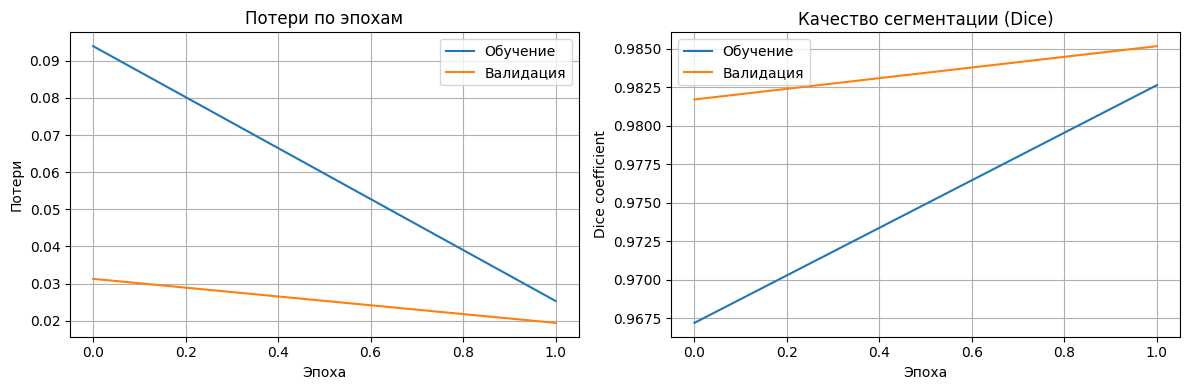

In [ ]:
# 1. Инициализация
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, out_channels=1).to(device)
criterion = CombinedLoss(alpha=0.5)  # Комбинированная потеря
optimizer = Adam(model.parameters(), lr=1e-4)

print(f"🎯 Устройство: {device}")
print(f"🧠 Модель: U-Net")
print(f"📊 Параметров: {sum(p.numel() for p in model.parameters()):,}")
print(f"📈 Функция потерь: Combined Loss (Dice + BCE)")
print(f"🚀 Начинаю обучение...")

# 2. Обучение на 2 эпохах
num_epochs = 2
history = {'train_loss': [], 'train_dice': [], 'val_loss': [], 'val_dice': []}

for epoch in range(num_epochs):
    start_time = time.time()
    print(f"\n{'='*60}")
    print(f"Эпоха {epoch+1}/{num_epochs}")

    # Обучение
    train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)

    # Валидация
    val_loss, val_dice = validate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)

    epoch_time = time.time() - start_time
    print(f"   Время: {epoch_time:.1f} сек")
    print(f"   Потери: обучение={train_loss:.4f}, валидация={val_loss:.4f}")
    print(f"   Dice: обучение={train_dice:.4f}, валидация={val_dice:.4f}")

print(f"\n{'='*60}")
print("✅ Обучение завершено!")

# 3. Графики
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history['train_loss'], label='Обучение')
axes[0].plot(history['val_loss'], label='Валидация')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Потери')
axes[0].set_title('Потери по эпохам')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_dice'], label='Обучение')
axes[1].plot(history['val_dice'], label='Валидация')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Dice coefficient')
axes[1].set_title('Качество сегментации (Dice)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

🧪 Быстрая проверка модели на 3 примерах...


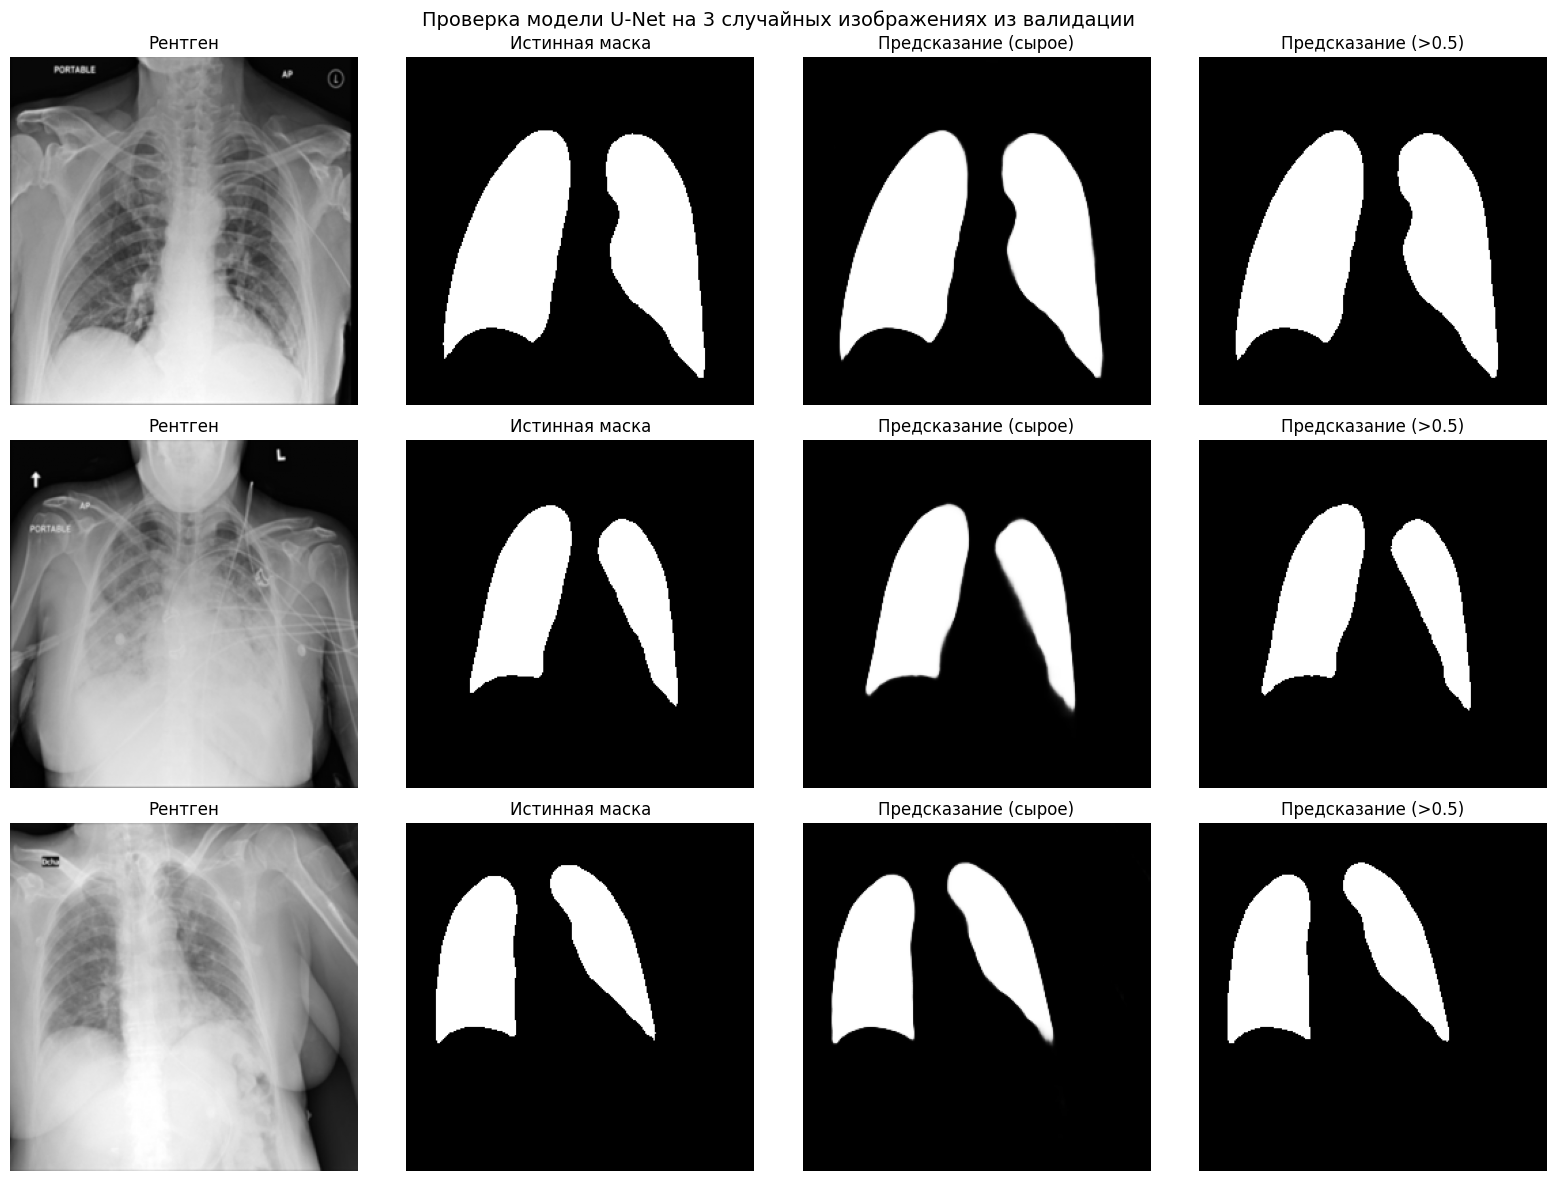


📊 Dice coefficient на этих примерах:
  Пример 1: Dice = 0.9887
  Пример 2: Dice = 0.9898
  Пример 3: Dice = 0.9635


In [ ]:
# Берём 3 случайных примера из валидации
print("🧪 Быстрая проверка модели на 3 примерах...")
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(3):
    idx = torch.randint(0, len(val_dataset), (1,)).item()
    image, true_mask = val_dataset[idx]

    # Предсказание модели
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)  # [1, 1, H, W]
        pred = model(image_tensor)
        pred_binary = (pred > 0.5).float()

    # Денормализация для отображения (если нужно)
    img_display = image[0].cpu().numpy()  # [H, W]
    true_mask_display = true_mask[0].cpu().numpy()
    pred_display = pred[0][0].cpu().numpy()
    pred_binary_display = pred_binary[0][0].cpu().numpy()

    # Визуализация
    axes[i, 0].imshow(img_display, cmap='gray')
    axes[i, 0].set_title("Рентген")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(true_mask_display, cmap='gray')
    axes[i, 1].set_title("Истинная маска")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(pred_display, cmap='gray')
    axes[i, 2].set_title("Предсказание (сырое)")
    axes[i, 2].axis('off')

    axes[i, 3].imshow(pred_binary_display, cmap='gray')
    axes[i, 3].set_title("Предсказание (>0.5)")
    axes[i, 3].axis('off')

plt.suptitle("Проверка модели U-Net на 3 случайных изображениях из валидации", fontsize=14)
plt.tight_layout()
plt.show()

# Посчитаем Dice на этих примерах
print("\n📊 Dice coefficient на этих примерах:")
for i in range(3):
    idx = torch.randint(0, len(val_dataset), (1,)).item()
    image, true_mask = val_dataset[idx]

    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        pred = model(image_tensor)
        pred_binary = (pred > 0.5).float()
        dice = dice_coeff(pred_binary, true_mask.unsqueeze(0).to(device))

    print(f"  Пример {i+1}: Dice = {dice:.4f}")

## *Детекция патологий на КТ почек*

### *Визуализация исходных данных*

📁 Содержимое папки:
  - README.roboflow.txt
  - README.dataset.txt
  - data.yaml
  - kidney_stone.zip
  - .ipynb_checkpoints
  - test
  - train
  - valid

✅ Нашел конфиг: /content/drive/MyDrive/medical-project/kidney_data/data.yaml

📋 Конфигурация:
  Train: /content/drive/MyDrive/medical-project/kidney_data/train/images
  Val: /content/drive/MyDrive/medical-project/kidney_data/valid/images
  Test: /content/drive/MyDrive/medical-project/kidney_data/test/images


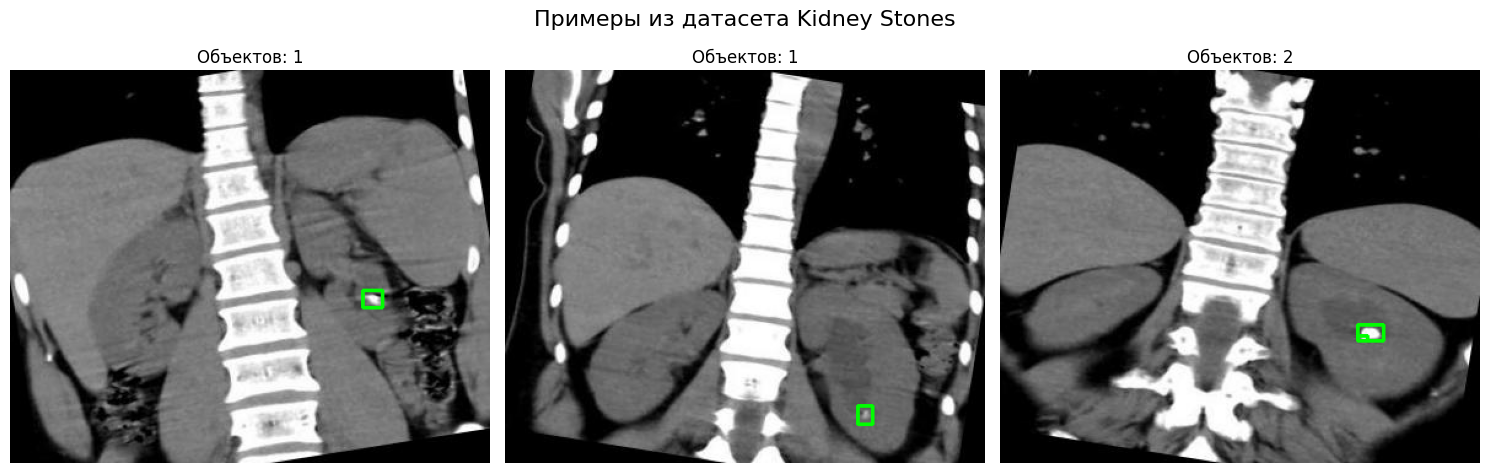

✅ Всего изображений в train: 1054


In [ ]:
# Путь к датасету
dataset_path = Path("medical-project/kidney_data")
print("📁 Содержимое папки:")
for item in dataset_path.iterdir():
    print(f"  - {item.name}")
yaml_path = dataset_path / "data.yaml"
print(f"\n✅ Нашел конфиг: {yaml_path}")

# Загружаем и сразу исправляем пути
with open(yaml_path, 'r') as f:
    config = yaml.safe_load(f)

for key in ['train', 'val', 'test']:
    if config[key].startswith('../'):
        config[key] = config[key].replace('../', '', 1)
    config[key] = str(dataset_path / config[key])
print("\n📋 Конфигурация:")
print(f"  Train: {config.get('train')}")
print(f"  Val: {config.get('val')}")
print(f"  Test: {config.get('test')}")

# Показываем пример
img_dir = Path(config['train'])
images = list(img_dir.glob("*.jpg"))

if images:
    # Берём 3 случайные картинки
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i in range(3):
        img_path = random.choice(images)
        label_path = img_path.parent.parent / "labels" / f"{img_path.stem}.txt"

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if label_path.exists():
            with open(label_path, 'r') as f:
                lines = f.readlines()

            h, w = img.shape[:2]
            for line in lines:
                cls, xc, yc, bw, bh = map(float, line.strip().split())
                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        axes[i].imshow(img)
        axes[i].set_title(f"Объектов: {len(lines) if 'lines' in locals() else 0}")
        axes[i].axis('off')

    plt.suptitle("Примеры из датасета Kidney Stones", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("❌ Нет изображений")

print(f"✅ Всего изображений в train: {len(images)}")

### *Обучение модели YOLOv8s*

In [ ]:
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Загружаем среднюю модель
model = YOLO("yolov8s.pt")

# Обучаем
results = model.train(
    data="kidney_data/data.yaml",
    epochs=20,
    imgsz=640,
    batch=16,
    name="kidney_stone_yolo",
    patience=5,
    lr0=0.01,
    optimizer="AdamW",
    verbose=True
)

print("✅ Обучение завершено!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
GPU: Tesla T4
Memory: 15.8 GB
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/medical-project/kidney_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015,

### *Тестирование модели*

✅ Модель загружена

image 1/1 /content/drive/MyDrive/medical-project/kidney_data/test/images/1-3-46-670589-33-1-63715282588697485900001-4980671363637353986_png_jpg.rf.942e6d1d8c91713ebd262b0d50ebc83b.jpg: 544x640 1 Tas_Var, 17.8ms
Speed: 5.2ms preprocess, 17.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/medical-project/kidney_data/test/images/1-3-46-670589-33-1-63717795419239238700001-5010543312669228864_png_jpg.rf.a5329a41a44e18f916c7e0d2ccdba442.jpg: 544x640 1 Tas_Var, 28.2ms
Speed: 3.7ms preprocess, 28.2ms inference, 4.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/medical-project/kidney_data/test/images/1-3-46-670589-33-1-63738370133490411800001-5404980644211618423_png_jpg.rf.3a09d97eaf51aa1d631864d196be4c8e.jpg: 544x640 2 Tas_Vars, 30.1ms
Speed: 5.9ms preprocess, 30.1ms inference, 6.7ms postprocess per image at shape (1, 3, 544, 640)


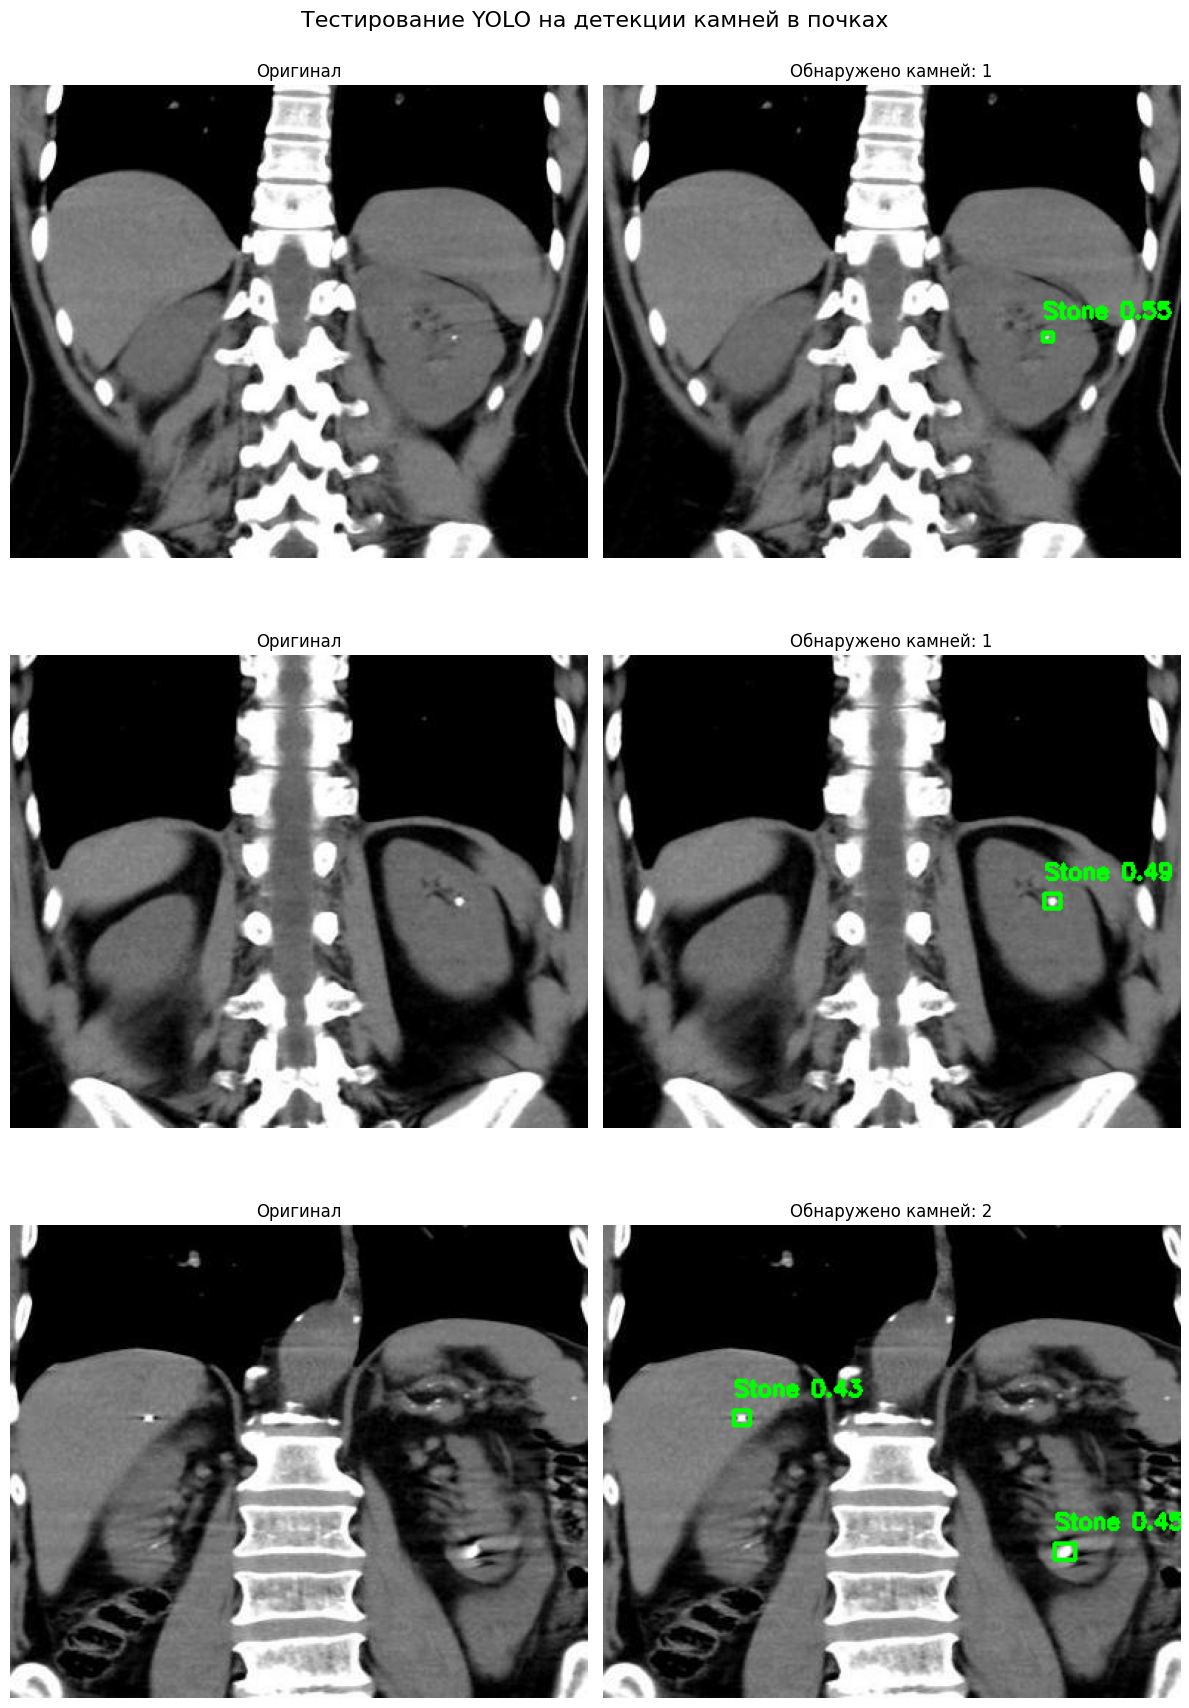

In [ ]:
# 1. Загружаем обученную модель
model_path = "cv_models/kidney_stones/best.pt"
model = YOLO(model_path)
print("✅ Модель загружена")

# 2. Берём тестовые изображения
data_dir = Path("/kidney_data")
test_images = list((data_dir / "test" / "images").glob("*.jpg"))[:3]

# 3. Тестируем
fig, axes = plt.subplots(len(test_images), 2, figsize=(12, 6*len(test_images)))

for i, img_path in enumerate(test_images):
    # Предсказание
    results = model.predict(str(img_path), conf=0.4)

    # Загружаем картинку
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_with_boxes = img_rgb.copy()

    # Рисуем bounding boxes
    if results[0].boxes is not None and len(results[0].boxes) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()

        for box, conf in zip(boxes, confs):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"Stone {conf:.2f}"
            cv2.putText(img_with_boxes, label, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        stone_count = len(boxes)
    else:
        stone_count = 0

    # Отображаем
    axes[i, 0].imshow(img_rgb)
    axes[i, 0].set_title(f"Оригинал")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(img_with_boxes)
    axes[i, 1].set_title(f"Обнаружено камней: {stone_count}")
    axes[i, 1].axis('off')

plt.suptitle("Тестирование YOLO на детекции камней в почках", fontsize=16)
plt.tight_layout()
plt.show()

# 4. Проверяем метрики
import pandas as pd
csv_path = Path("runs/detect/kidney_stone_yolo/results.csv")
if csv_path.exists():
    metrics = pd.read_csv(csv_path)
    print("\n📈 Метрики обучения:")
    print(f"  Лучший mAP50: {metrics['metrics/mAP50(B)'].max():.3f}")
    print(f"  Последний mAP50: {metrics['metrics/mAP50(B)'].iloc[-1]:.3f}")

## *Запуск интерфейса Gradio*

In [ ]:
cd /path/to/medical-project
python app.py